# Ad ROI Dashboard – Demo 3

This dashboard analyzes marketing campaign efficiency across digital sources and devices using real-world data. We calculate key metrics including ROAS, CPC, and Conversion Rate, and surface actionable insights.

---

### **Objective**
Evaluate advertising ROI, conversion rate, and customer acquisition cost across digital sources and devices.

### **Dataset**
The dataset includes advertising costs, website visits, and transaction logs from a US-based e-commerce platform.

### **Business Value**
This analysis helps detect underperforming campaigns, optimize ad budgets, and identify high-value channels by source and device.

### **Executive Summary** 

- **Top ROAS Sources**: Source 1 and 2 consistently outperform with ROAS > 5.
- **Efficiency Flag**: Sources 3, 6, and 9 show high CPC and low ROAS — need optimization.
- **Seasonal Peaks**: November shows clear spikes in revenue, likely due to campaigns (Black Friday).
---

### 📁 Notebook Structure
1. Data Overview & Loading 
2. Data Cleaning & Preprocessing 
3. Metric Aggregation & KPI Calculation 
4. Device Level Analysis  
5. Daily, Weekly & Monthly KPI Trends
6. Heatmaps & Channel Comparisons
7. Strategic Insights


In [1]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set options
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set_theme(style="whitegrid")


## 1. Data Overview & Loading

We begin by importing ad costs, visits, and transaction logs. Initial exploration confirms the datasets are structured correctly with consistent IDs and timestamps.

In [2]:
# Load datasets
costs = pd.read_csv("/Users/jacquelinehardy/Desktop/jh-data-studio-demos/demo-03-ad-roi-dashboard/data/costs_us.csv")
orders = pd.read_csv("/Users/jacquelinehardy/Desktop/jh-data-studio-demos/demo-03-ad-roi-dashboard/data/orders_log_us.csv")
visits = pd.read_csv("/Users/jacquelinehardy/Desktop/jh-data-studio-demos/demo-03-ad-roi-dashboard/data/visits_log_us.csv")

# Quick look
print("costs_us.csv:")
display(costs.head())

print("orders_log_us.csv:")
display(orders.head())

print("visits_log_us.csv:")
display(visits.head())


costs_us.csv:


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


orders_log_us.csv:


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


visits_log_us.csv:


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


## 2. Data Cleaning & Preprocessing

We extract campaign dates, parse timestamps, and align source IDs across all files to enable unified metric aggregation.

In [3]:
# Step 1: Prepare orders
orders['date'] = pd.to_datetime(orders['Buy Ts']).dt.date

In [4]:
# Aggregate revenue per date and source
orders_agg = (
    visits[['Uid', 'Source Id', 'Start Ts']]
    .merge(orders[['Uid', 'Revenue', 'date']], on='Uid', how='inner')
)

orders_kpi = (
    orders_agg
    .groupby(['date', 'Source Id'])
    .agg({'Revenue': 'sum', 'Uid': 'count'})  # Uid = number of orders
    .rename(columns={'Uid': 'Orders'})
    .reset_index()
)

In [5]:
# Step 2: Aggregate visits (clicks) per day & source
visits['date'] = pd.to_datetime(visits['Start Ts']).dt.date
visits_kpi = (
    visits
    .groupby(['date', 'Source Id'])
    .agg({'Uid': 'nunique'})
    .rename(columns={'Uid': 'Clicks'})
    .reset_index()
)


In [6]:
# Step 3: Aggregate costs
costs['date'] = pd.to_datetime(costs['dt']).dt.date
costs_kpi = costs.rename(columns={'source_id': 'Source Id', 'costs': 'Cost'})


In [7]:
# Step 4: Merge all
merged = (
    costs_kpi
    .merge(visits_kpi, on=['date', 'Source Id'], how='left')
    .merge(orders_kpi, on=['date', 'Source Id'], how='left')
)


In [8]:
# Step 5: Fill NAs
merged[['Clicks', 'Orders', 'Revenue']] = merged[['Clicks', 'Orders', 'Revenue']].fillna(0)


## 3. Metric Aggregation & KPI Calculation

We calculate the following marketing KPIs:
- **ROAS** = Revenue ÷ Cost  
- **CPC** = Cost ÷ Clicks  
- **Conversion Rate** = Orders ÷ Clicks  

Missing values and division errors are safely handled.

In [9]:
# Step 6: Compute KPIs
merged['ROAS'] = merged['Revenue'] / merged['Cost']
merged['CPC'] = merged['Cost'] / merged['Clicks']
merged['Conversion Rate'] = merged['Orders'] / merged['Clicks']

# Clean divisions
merged.replace([np.inf, -np.inf], np.nan, inplace=True)
merged.fillna(0, inplace=True)


In [10]:
# Final KPI table
merged.sort_values(['date', 'Source Id']).head()


,Source Id,dt,Cost,date,Clicks,Revenue,Orders,ROAS,CPC,Conversion Rate
0,1,2017-06-01,75.20,2017-06-01,61.00,596.81,208.00,7.94,1.23,3.41
363,2,2017-06-01,132.56,2017-06-01,79.00,405.08,265.00,3.06,1.68,3.35
726,3,2017-06-01,349.38,2017-06-01,182.00,214.56,82.00,0.61,1.92,0.45
1089,4,2017-06-01,76.74,2017-06-01,138.00,344.31,107.00,4.49,0.56,0.78
1452,5,2017-06-01,73.24,2017-06-01,114.00,304.46,155.00,4.16,0.64,1.36


In [11]:
# Merge visits with orders
visits_orders = visits.merge(orders[['Uid', 'Revenue']], on='Uid', how='left')
visits_orders['date'] = pd.to_datetime(visits_orders['Start Ts']).dt.date


## 4. Device-Level Analysis

We break down campaign performance by desktop vs. touch devices to uncover behavioral and conversion efficiency differences.


In [12]:
# Aggregate by date + Source Id + Device
device_agg = visits_orders.groupby(['date', 'Source Id', 'Device'], as_index=False).agg({
    'Uid': 'count',
    'Revenue': 'sum'
}).rename(columns={
    'Uid': 'Clicks'
})


In [13]:
# Estimate orders by counting Uid with revenue present
orders_by_device = (
    visits_orders[visits_orders['Revenue'].notnull()]
    .groupby(['date', 'Source Id', 'Device'])['Uid']
    .count()
    .reset_index(name='Orders')
)

# Merge with clicks + revenue
device_agg = device_agg.merge(orders_by_device, on=['date', 'Source Id', 'Device'], how='left')
device_agg['Orders'] = device_agg['Orders'].fillna(0)


In [14]:
# Costs by date + Source Id (rename source_id to match)
costs_agg = costs.groupby(['date', 'source_id'], as_index=False)['costs'].sum()
costs_agg = costs_agg.rename(columns={'source_id': 'Source Id', 'costs': 'Cost'})



In [15]:
# Merge device-level data with cost data
kpi_by_device = device_agg.merge(costs_agg, on=['date', 'Source Id'], how='left')

In [16]:
# Compute KPIs
kpi_by_device['ROAS'] = kpi_by_device['Revenue'] / kpi_by_device['Cost']
kpi_by_device['CPC'] = kpi_by_device['Cost'] / kpi_by_device['Clicks']
kpi_by_device['Conversion Rate'] = kpi_by_device['Orders'] / kpi_by_device['Clicks']

# Clean up
kpi_by_device.replace([np.inf, -np.inf], np.nan, inplace=True)
kpi_by_device.fillna(0, inplace=True)

# Round KPIs
kpi_by_device[['ROAS', 'CPC', 'Conversion Rate']] = kpi_by_device[[
    'ROAS', 'CPC', 'Conversion Rate'
]].round(4)

# Preview
kpi_by_device.head()


,date,Source Id,Device,Clicks,Revenue,Orders,Cost,ROAS,CPC,Conversion Rate
0,2017-06-01,1,desktop,765,"6,162.37",741.00,75.20,81.95,0.10,0.97
1,2017-06-01,1,touch,34,191.77,28.00,75.20,2.55,2.21,0.82
2,2017-06-01,2,desktop,472,"4,129.96",435.00,132.56,31.16,0.28,0.92
3,2017-06-01,2,touch,29,75.44,18.00,132.56,0.57,4.57,0.62
4,2017-06-01,3,desktop,192,403.36,81.00,349.38,1.15,1.82,0.42


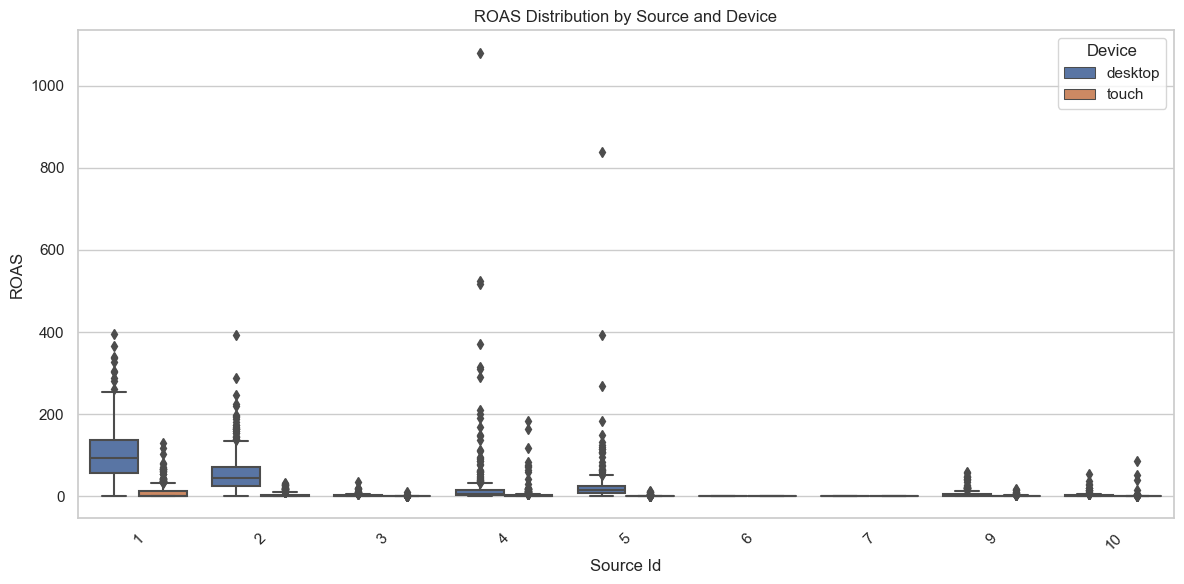

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set default style
sns.set(style="whitegrid")

# Plot ROAS by Source and Device
plt.figure(figsize=(12, 6))
sns.boxplot(x='Source Id', y='ROAS', hue='Device', data=kpi_by_device)
plt.title("ROAS Distribution by Source and Device")
plt.ylabel("ROAS")
plt.xlabel("Source Id")
plt.xticks(rotation=45)
plt.legend(title='Device')
plt.tight_layout()
plt.show()


**📌 Insight:**  
Source 1 shows significantly higher ROAS across both desktop and touch. Sources 4 and 5 underperform with high cost and low returns.


In [18]:
# Mean KPIs per source and device
summary_kpi = (
    kpi_by_device
    .groupby(['Source Id', 'Device'])[['ROAS', 'CPC', 'Conversion Rate']]
    .mean()
    .round(3)
    .sort_values(by='ROAS', ascending=False)
    .reset_index()
)

summary_kpi


,Source Id,Device,ROAS,CPC,Conversion Rate
0,1,desktop,104.87,0.15,0.92
1,2,desktop,57.37,0.27,0.88
2,5,desktop,24.33,0.42,0.70
3,4,desktop,23.73,0.72,0.46
4,1,touch,10.15,1.98,0.55
5,9,desktop,5.43,1.07,0.54
6,4,touch,4.68,1.82,0.25
7,2,touch,3.44,2.73,0.53
8,3,desktop,2.14,1.72,0.40
9,10,desktop,2.13,1.00,0.32


**📌 Observation:**  
On average, desktop users have higher ROAS and conversion rates compared to touch users, indicating better performance on larger screens.


## 5. Daily, Weekly, and Monthly KPI Trends

We now analyze KPI trends over time to evaluate campaign consistency, seasonal effects, and peak performance windows.

In [19]:
# Aggregate KPIs daily by Source
daily_kpis = (
    kpi_by_device
    .groupby(['date', 'Source Id'])[['Revenue', 'Cost', 'Clicks', 'Orders']]
    .sum()
    .reset_index()
)

# Compute daily KPIs
daily_kpis['ROAS'] = daily_kpis['Revenue'] / daily_kpis['Cost']
daily_kpis['CPC'] = daily_kpis['Cost'] / daily_kpis['Clicks']
daily_kpis['Conversion Rate'] = daily_kpis['Orders'] / daily_kpis['Clicks']

# Replace NaNs/Infs from division
daily_kpis.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_kpis.fillna(0, inplace=True)


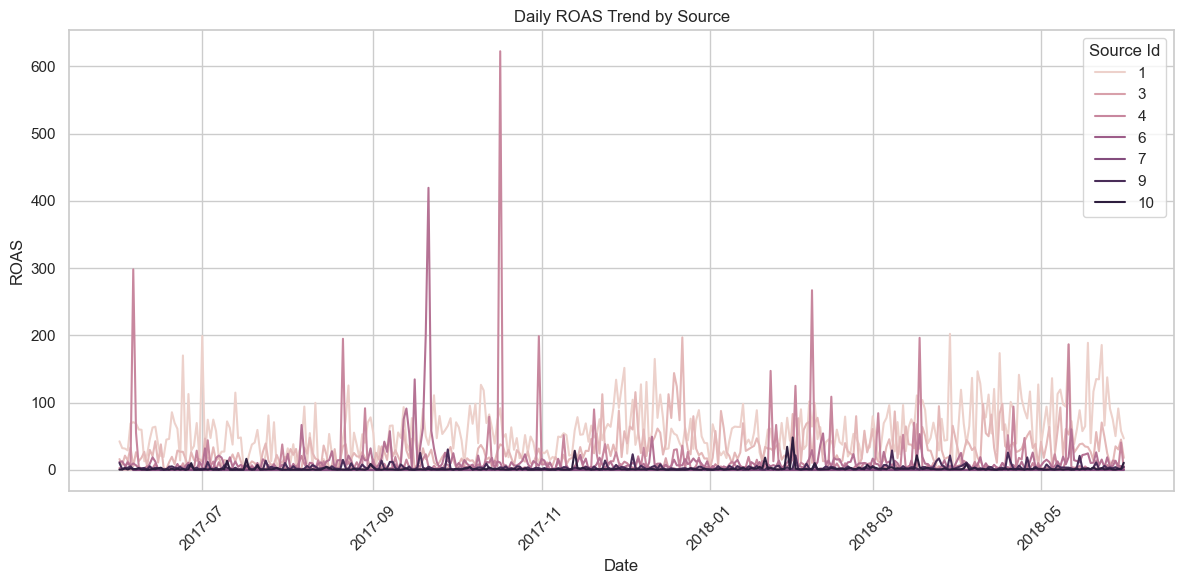

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_kpis, x='date', y='ROAS', hue='Source Id')
plt.title("Daily ROAS Trend by Source")
plt.xlabel("Date")
plt.ylabel("ROAS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


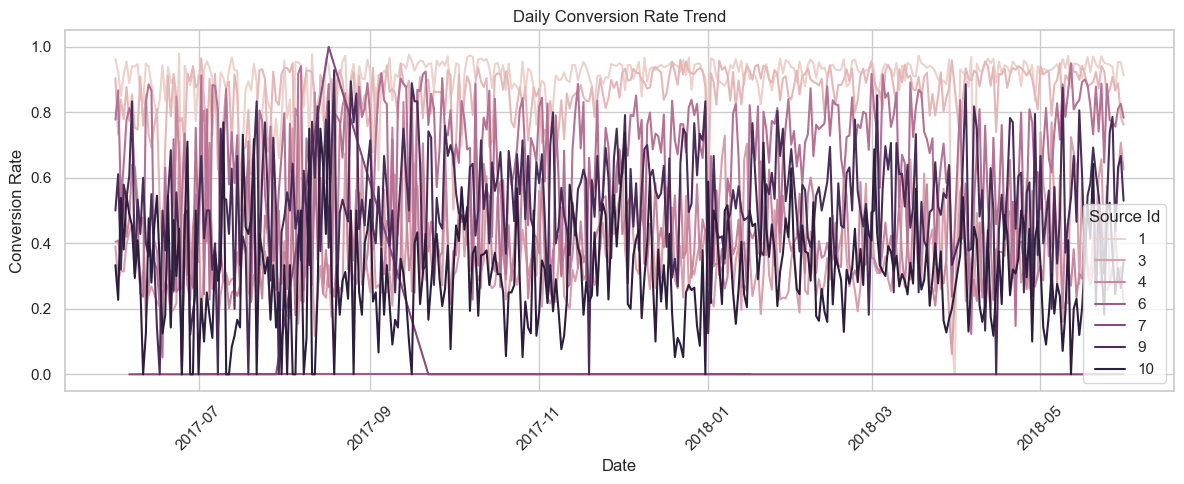

In [21]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_kpis, x='date', y='Conversion Rate', hue='Source Id')
plt.title("Daily Conversion Rate Trend")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
# Sort values before cumulative calculation
daily_kpis = daily_kpis.sort_values(['Source Id', 'date'])

# Compute cumulative sums
daily_kpis['Cumulative Cost'] = daily_kpis.groupby('Source Id')['Cost'].cumsum()
daily_kpis['Cumulative Revenue'] = daily_kpis.groupby('Source Id')['Revenue'].cumsum()
daily_kpis['Cumulative ROAS'] = daily_kpis['Cumulative Revenue'] / daily_kpis['Cumulative Cost']

# Replace inf/nan
daily_kpis.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_kpis.fillna(0, inplace=True)


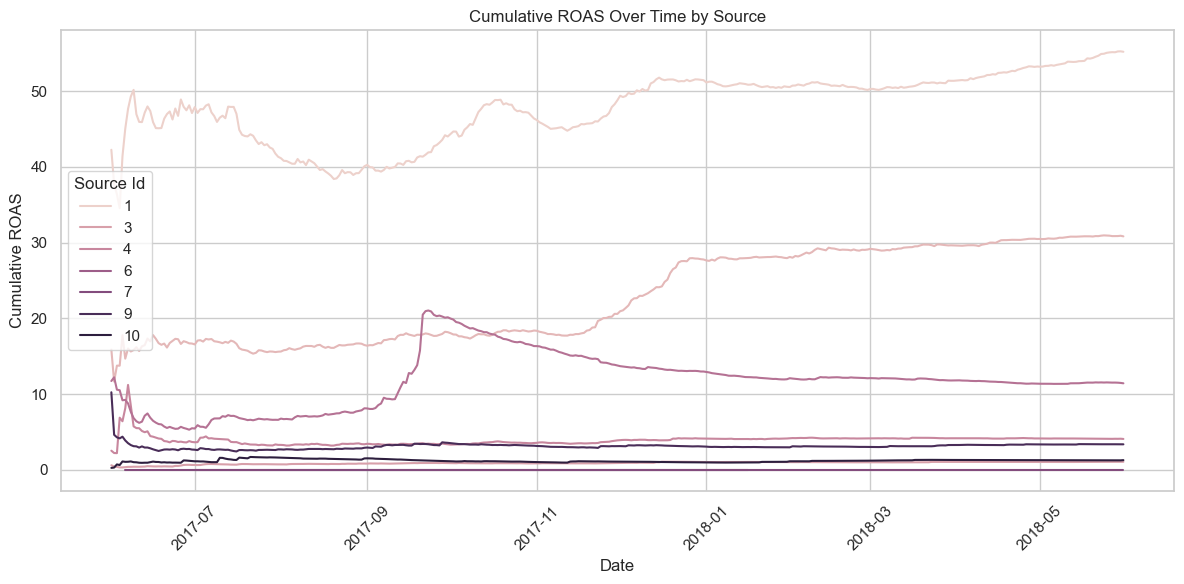

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_kpis, x='date', y='Cumulative ROAS', hue='Source Id')
plt.title("Cumulative ROAS Over Time by Source")
plt.xlabel("Date")
plt.ylabel("Cumulative ROAS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**📌 Trend Insight:**  
Cumulative ROAS shows flattening for several sources after Q4, while Source 1 continues to grow steadily into the new year.


In [24]:
# Ensure 'date' is datetime
daily_kpis['date'] = pd.to_datetime(daily_kpis['date'])

# Extract week and month
daily_kpis['Week'] = daily_kpis['date'].dt.to_period('W').apply(lambda r: r.start_time)
daily_kpis['Month'] = daily_kpis['date'].dt.to_period('M').dt.to_timestamp()


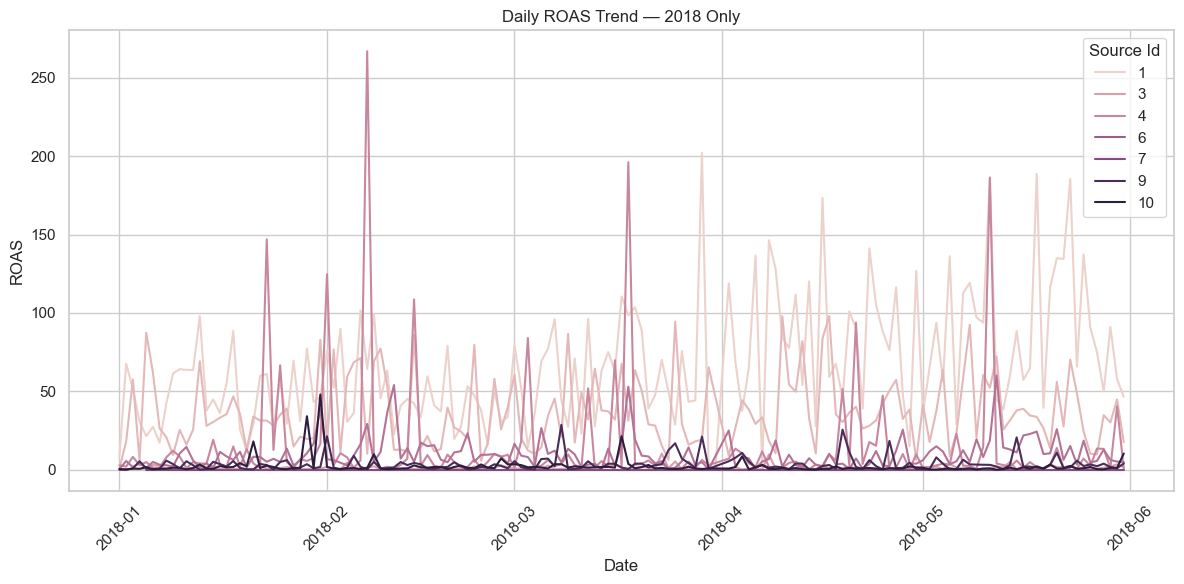

In [25]:
# Filter recent period (e.g. only 2018)
recent_trend = daily_kpis[daily_kpis['date'].dt.year == 2018]

# Example: ROAS trend for 2018 only
plt.figure(figsize=(12, 6))
sns.lineplot(data=recent_trend, x='date', y='ROAS', hue='Source Id')
plt.title("Daily ROAS Trend — 2018 Only")
plt.xlabel("Date")
plt.ylabel("ROAS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
# WEEKLY KPIs
weekly_kpis = (
    daily_kpis
    .groupby(['Week', 'Source Id'], as_index=False)
    .agg({'Revenue': 'sum', 'Cost': 'sum', 'Clicks': 'sum', 'Orders': 'sum'})
)

weekly_kpis['ROAS'] = weekly_kpis['Revenue'] / weekly_kpis['Cost']
weekly_kpis['CPC'] = weekly_kpis['Cost'] / weekly_kpis['Clicks']
weekly_kpis['Conversion Rate'] = weekly_kpis['Orders'] / weekly_kpis['Clicks']
weekly_kpis.replace([np.inf, -np.inf], np.nan, inplace=True)
weekly_kpis.fillna(0, inplace=True)

# MONTHLY KPIs
monthly_kpis = (
    daily_kpis
    .groupby(['Month', 'Source Id'], as_index=False)
    .agg({'Revenue': 'sum', 'Cost': 'sum', 'Clicks': 'sum', 'Orders': 'sum'})
)

monthly_kpis['ROAS'] = monthly_kpis['Revenue'] / monthly_kpis['Cost']
monthly_kpis['CPC'] = monthly_kpis['Cost'] / monthly_kpis['Clicks']
monthly_kpis['Conversion Rate'] = monthly_kpis['Orders'] / monthly_kpis['Clicks']
monthly_kpis.replace([np.inf, -np.inf], np.nan, inplace=True)
monthly_kpis.fillna(0, inplace=True)


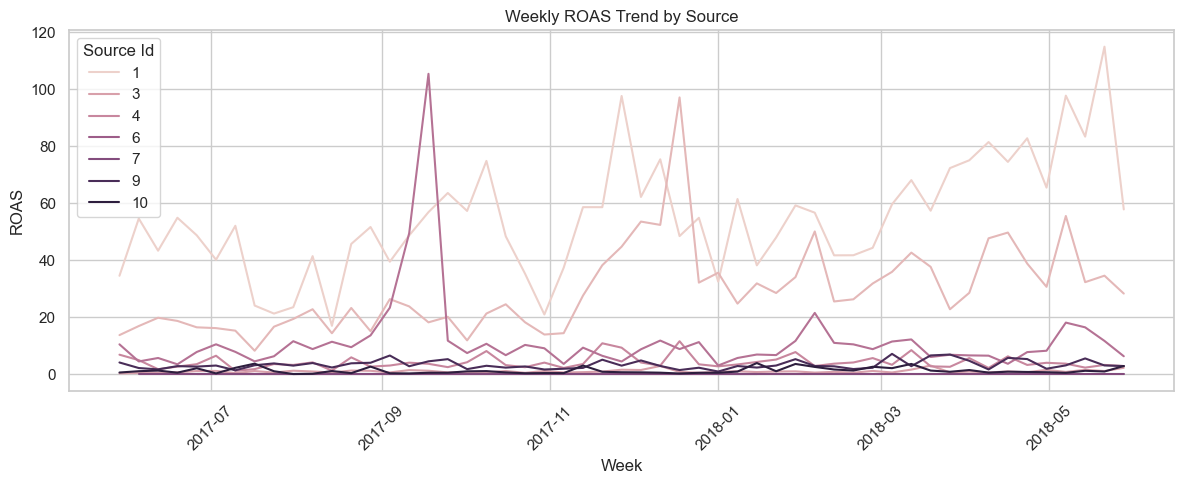

In [27]:
# Weekly ROAS Trend
plt.figure(figsize=(12, 5))
sns.lineplot(data=weekly_kpis, x='Week', y='ROAS', hue='Source Id')
plt.title("Weekly ROAS Trend by Source")
plt.xlabel("Week")
plt.ylabel("ROAS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

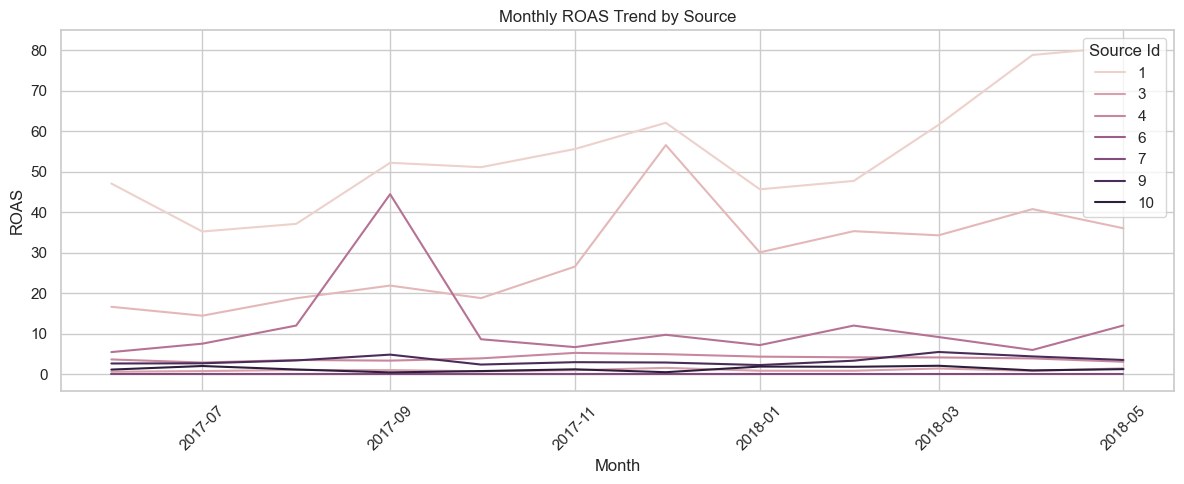

In [28]:
# Monthly ROAS Trend
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_kpis, x='Month', y='ROAS', hue='Source Id')
plt.title("Monthly ROAS Trend by Source")
plt.xlabel("Month")
plt.ylabel("ROAS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**📌 Monthly View:**  
Performance spikes in November suggest strong holiday campaign effects. Early-year performance is more stable across channels.


In [29]:
# Top 5 Sources by Average ROAS
top_sources = (
    merged.groupby('Source Id')['ROAS']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
    .rename(columns={'ROAS': 'Avg ROAS'})
)
top_sources.style.background_gradient(cmap='Greens')


,Source Id,Avg ROAS
0,1,117.563464
1,2,57.237382
2,4,30.865788
3,5,22.120924
4,9,7.000153


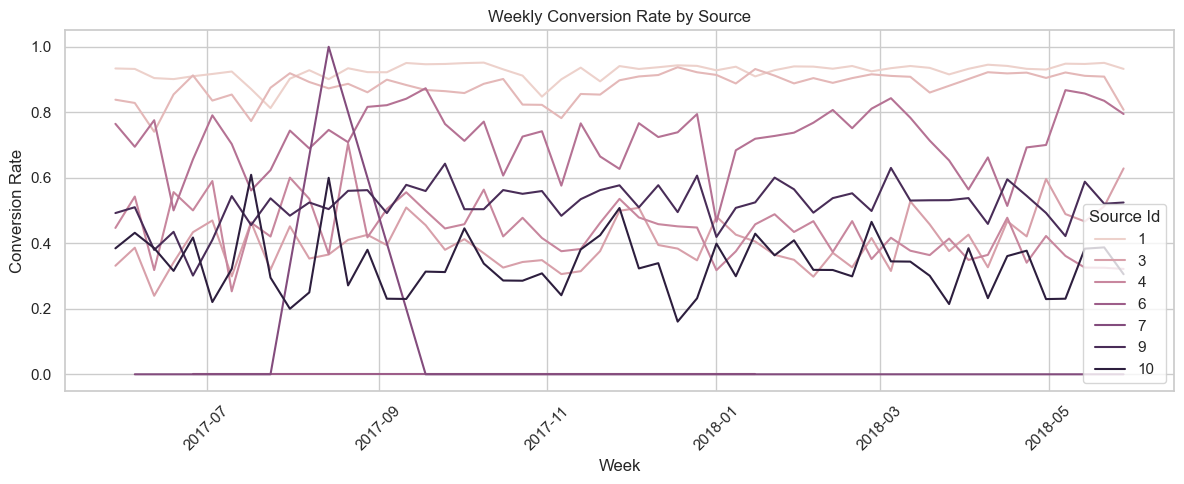

In [30]:
# Weekly Conversion Rate
plt.figure(figsize=(12, 5))
sns.lineplot(data=weekly_kpis, x='Week', y='Conversion Rate', hue='Source Id')
plt.title("Weekly Conversion Rate by Source")
plt.xlabel("Week")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

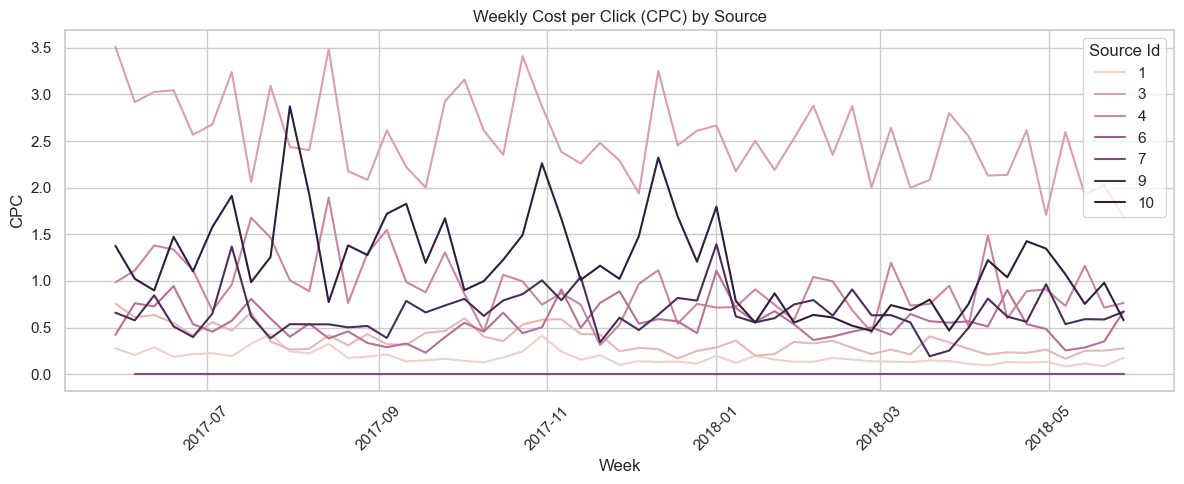

In [31]:
# Weekly CPC
plt.figure(figsize=(12, 5))
sns.lineplot(data=weekly_kpis, x='Week', y='CPC', hue='Source Id')
plt.title("Weekly Cost per Click (CPC) by Source")
plt.xlabel("Week")
plt.ylabel("CPC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

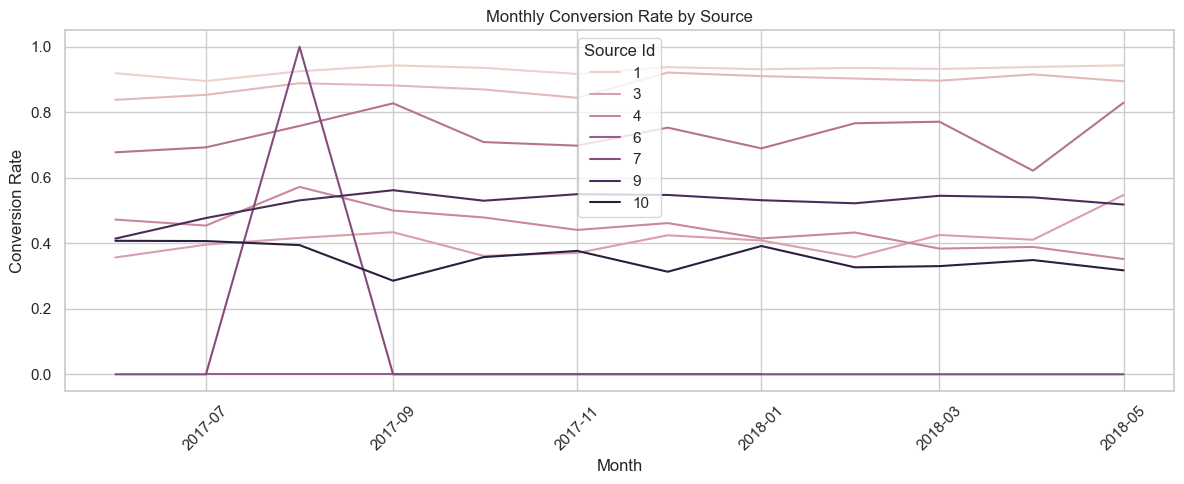

In [32]:
# Monthly Conversion Rate
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_kpis, x='Month', y='Conversion Rate', hue='Source Id')
plt.title("Monthly Conversion Rate by Source")
plt.xlabel("Month")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

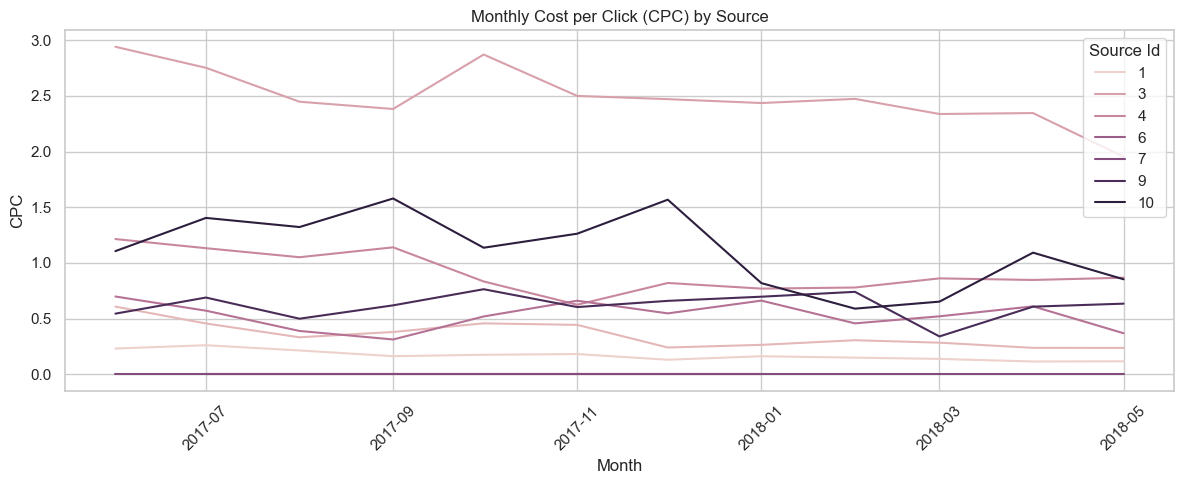

In [33]:
# Monthly CPC
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_kpis, x='Month', y='CPC', hue='Source Id')
plt.title("Monthly Cost per Click (CPC) by Source")
plt.xlabel("Month")
plt.ylabel("CPC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Group by Month and Source Id
monthly_summary = (
    kpi_by_device
    .groupby([kpi_by_device['date'].astype('datetime64[M]'), 'Source Id'])
    [['Revenue', 'Cost', 'Clicks', 'Orders']]
    .sum()
    .reset_index()
)

# Compute KPIs
monthly_summary['ROAS'] = monthly_summary['Revenue'] / monthly_summary['Cost']
monthly_summary['CPC'] = monthly_summary['Cost'] / monthly_summary['Clicks']
monthly_summary['Conversion Rate'] = monthly_summary['Orders'] / monthly_summary['Clicks']

# Round and sort
monthly_summary[['ROAS', 'CPC', 'Conversion Rate']] = monthly_summary[[
    'ROAS', 'CPC', 'Conversion Rate'
]].round(3)

monthly_summary = monthly_summary.sort_values(['date', 'Source Id']).reset_index(drop=True)

# Preview
monthly_summary.head()


,date,Source Id,Revenue,Cost,Clicks,Orders,ROAS,CPC,Conversion Rate
0,2017-06-01,1,"106,036.37","2,251.22",9737,"8,951.00",47.10,0.23,0.92
1,2017-06-01,2,"80,902.52","4,854.76",7990,"6,695.00",16.66,0.61,0.84
2,2017-06-01,3,"9,742.17","15,463.30",5259,"1,876.00",0.63,2.94,0.36
3,2017-06-01,4,"25,763.35","7,029.60",5790,"2,735.00",3.67,1.21,0.47
4,2017-06-01,5,"28,672.73","5,232.24",7492,"5,078.00",5.48,0.70,0.68


## 6. Heatmaps & Channel Comparison

Side-by-side comparison helps identify device-specific anomalies and guide budget allocation.


In [35]:
# Aggregate KPIs by Source and Device
device_summary = (
    kpi_by_device
    .groupby(['Source Id', 'Device'])
    [['Revenue', 'Cost', 'Clicks', 'Orders']]
    .sum()
    .reset_index()
)

# Compute KPIs
device_summary['ROAS'] = device_summary['Revenue'] / device_summary['Cost']
device_summary['CPC'] = device_summary['Cost'] / device_summary['Clicks']
device_summary['Conversion Rate'] = device_summary['Orders'] / device_summary['Clicks']

# Round
device_summary[['ROAS', 'CPC', 'Conversion Rate']] = device_summary[[
    'ROAS', 'CPC', 'Conversion Rate'
]].round(3)

# Display with styling
device_summary.sort_values(['Source Id', 'Device'])


,Source Id,Device,Revenue,Cost,Clicks,Orders,ROAS,CPC,Conversion Rate
0,1,desktop,"2,095,264.41","20,833.27",249344,"236,711.00",100.57,0.08,0.95
1,1,touch,"202,935.76","20,810.19",17286,"11,951.00",9.75,1.20,0.69
2,2,desktop,"2,473,934.81","42,806.04",244828,"224,404.00",57.79,0.17,0.92
3,2,touch,"164,254.40","42,806.04",22032,"13,893.00",3.84,1.94,0.63
4,3,desktop,"270,702.22","141,321.63",92536,"41,628.00",1.92,1.53,0.45
5,3,touch,"25,985.74","141,321.63",21839,"5,138.00",0.18,6.47,0.23
6,4,desktop,"410,784.11","61,073.60",103025,"51,867.00",6.73,0.59,0.50
7,4,touch,"85,906.06","61,073.60",39441,"10,816.00",1.41,1.55,0.27
8,5,desktop,"1,155,946.97","51,756.40",185326,"147,721.00",22.33,0.28,0.80
9,5,touch,"25,530.17","51,756.40",18595,"4,103.00",0.49,2.78,0.22


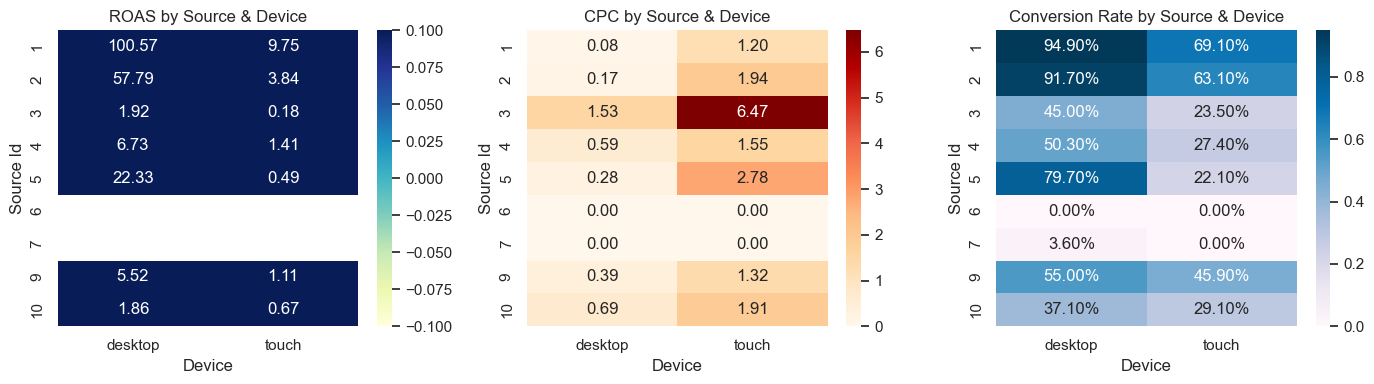

In [36]:
# Pivot data
roas_pivot = device_summary.pivot(index='Source Id', columns='Device', values='ROAS')
cpc_pivot = device_summary.pivot(index='Source Id', columns='Device', values='CPC')
cr_pivot = device_summary.pivot(index='Source Id', columns='Device', values='Conversion Rate')

# Plot heatmaps
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.heatmap(roas_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("ROAS by Source & Device")

plt.subplot(1, 3, 2)
sns.heatmap(cpc_pivot, annot=True, fmt=".2f", cmap="OrRd")
plt.title("CPC by Source & Device")

plt.subplot(1, 3, 3)
sns.heatmap(cr_pivot, annot=True, fmt=".2%", cmap="PuBu")
plt.title("Conversion Rate by Source & Device")

plt.tight_layout()
plt.show()

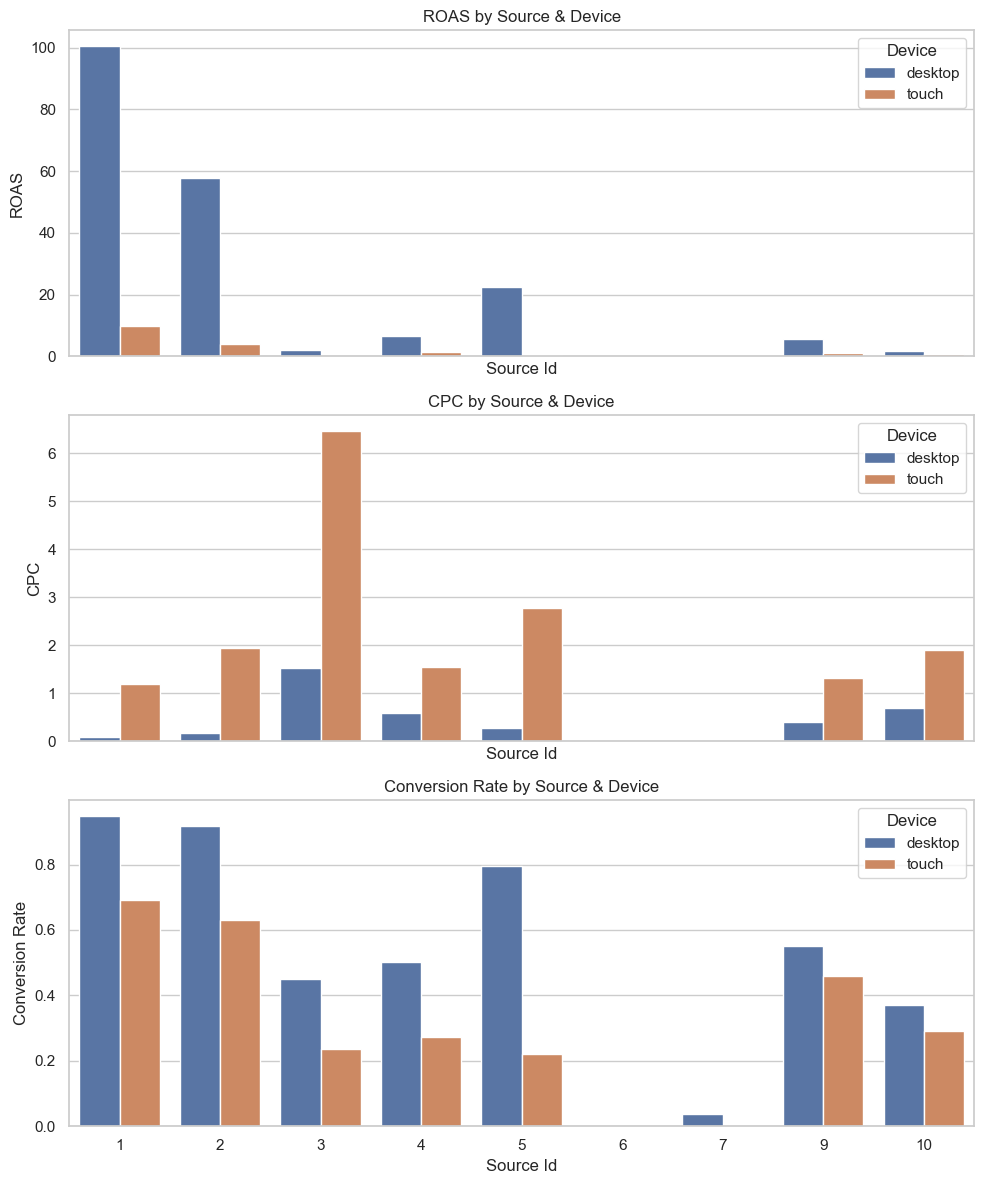

In [37]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

sns.barplot(data=device_summary, x='Source Id', y='ROAS', hue='Device', ax=axes[0])
axes[0].set_title("ROAS by Source & Device")

sns.barplot(data=device_summary, x='Source Id', y='CPC', hue='Device', ax=axes[1])
axes[1].set_title("CPC by Source & Device")

sns.barplot(data=device_summary, x='Source Id', y='Conversion Rate', hue='Device', ax=axes[2])
axes[2].set_title("Conversion Rate by Source & Device")

plt.tight_layout()
plt.show()


In [42]:
# Calculate average CPC and ROAS by Source Id
kpi_flags = (
    merged.groupby('Source Id')[['CPC', 'ROAS']]
    .mean()
    .round(3)
    .reset_index()
)

# Add flag column
kpi_flags['Flag'] = ''

# Flag conditions
kpi_flags.loc[kpi_flags['CPC'] > 1.0, 'Flag'] += 'High CPC '
kpi_flags.loc[kpi_flags['ROAS'] < 5, 'Flag'] += 'Low ROAS'


# Strip whitespace
kpi_flags['Flag'] = kpi_flags['Flag'].str.strip()

# Show only flagged rows with styling
kpi_flags[kpi_flags['Flag'] != ''].style.background_gradient(cmap='OrRd', subset=['CPC', 'ROAS'])


,Source Id,CPC,ROAS,Flag
1,2,1.018000,57.237000,High CPC
2,3,1.704000,2.401000,High CPC Low ROAS
6,10,0.817000,3.196000,Low ROAS


## 7. Strategic Insights

The dashboard surfaces key patterns to help improve marketing performance.

---

**🎯 Key Takeaways:**

- **Top Performers:** Sources 1 and 2 deliver the best ROAS.
- **Device Trends:** Desktop drives more efficient traffic with higher conversion rates.
- **Optimization Need:** Sources 3, 5 and 9 show high CPC with minimal return — consider reallocating budget.
- **Seasonality:** ROAS peaks in November hint at holiday season opportunity.

---

**🛠 Next Steps:**

- Prioritize high-ROAS channels for budget increases.
- Investigate mobile UX to improve conversion on touch devices.
- Pause or optimize low-efficiency campaigns.
- Monitor KPIs monthly to adjust bidding strategy dynamically.


In [39]:
# Export cleaned KPIs
merged.to_csv("kpi_summary.csv", index=False)
print("✔ KPI summary saved to 'kpi_summary.csv'")


✔ KPI summary saved to 'kpi_summary.csv'
